In [70]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
from scipy import optimize

# Maze task basic results

In [79]:
def links(environment,rooms):
    theta = np.zeros([rooms,4])
    for i in range(environment.shape[0]):
        for j in range(environment.shape[1]):
            value = environment[i,j]
            left = j-1
            if(left<0):
                left = environment.shape[1]-1
            right = j+1
            if(right==environment.shape[1]):
                right = 0
            up = i-1
            if(up<0):
                up = environment.shape[0]-1
            down = i+1
            if(down==environment.shape[0]):
                down = 0
            theta[value-1,0] = environment[i,left]
            theta[value-1,1] = environment[i,right]
            theta[value-1,2] = environment[up,j]
            theta[value-1,3] = environment[down,j]
    return theta.astype(int)

In [86]:
def KL_dirichlet(m,n):
    kl = 0
    kl += np.log(sp.gamma(np.sum(m)))
    kl -= np.log(sp.gamma(np.sum(n)))
    kl -= np.sum(np.log(sp.gamma(m)))
    kl += np.sum(np.log(sp.gamma(n)))
    kl += np.sum((m-n)*(sp.psi(m)-sp.psi(np.sum(m))))
    
    return kl



## Basic algorithm

In [126]:
np.random.seed(945)

N = 100000
rooms = 16
alpha = np.ones([rooms,rooms])
shift_env = 0.01
env_mark = 0
m = 0.1
gamma = 0.5
s = np.random.randint(0,16)
env_A = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
env_B = np.array([[6,3,5,13],[1,7,4,8],[9,15,12,14],[10,11,16,2]])
environment = env_A
theta = links(environment, rooms)
change_point = []
alpha_time = np.zeros([rooms,rooms,N])

for n in range(N):
    if((n+1)%(N/10) == 0):
        print("Iteration {} out of {}".format(n+1,N))
    coin = np.random.rand()
    if(coin < shift_env):
        change_point.append(n)
        if(env_mark == 0):
            env_mark = 1
            environment = env_B
            theta = links(environment,rooms)
        else:
            env_mark = 0
            environment = env_A
            theta = links(environment,rooms)

    new_room = np.random.randint(0,4)
    s_prime = theta[s,new_room]-1
    likelihood = np.ones(rooms)
    likelihood[s_prime] += 1
    a = np.delete(alpha[s,:],s)
    b = np.delete(likelihood,s)
    surprise = KL_dirichlet(a,b)
    B_max = KL_dirichlet(b,a)
    B = (m*surprise/(1+m*surprise))*B_max
    def F(x):
        return (KL_dirichlet(x*b + (1-x)*a,a) - B)
    gamma = optimize.newton(F,gamma)
    alpha[s,:] = (1-gamma)*alpha[s,:] + gamma*likelihood
    alpha_time[:,:,n] = alpha
    s = s_prime
    

        

Iteration 10000 out of 100000
Iteration 20000 out of 100000
Iteration 30000 out of 100000
Iteration 40000 out of 100000
Iteration 50000 out of 100000
Iteration 60000 out of 100000
Iteration 70000 out of 100000
Iteration 80000 out of 100000
Iteration 90000 out of 100000
Iteration 100000 out of 100000


In [127]:
print(change_point)

[315, 465, 638, 817, 1058, 1139, 1157, 1265, 1497, 1677, 1700, 1810, 1831, 1924, 2053, 2071, 2145, 2217, 2296, 2477, 2557, 2643, 2648, 2690, 2790, 2811, 2917, 2980, 3067, 3141, 3193, 3259, 3315, 3324, 3461, 3510, 3584, 3600, 3697, 3716, 3761, 3771, 3811, 3824, 3999, 4031, 4125, 4181, 4267, 4324, 4366, 4501, 4883, 4949, 5184, 5441, 5523, 5526, 5529, 5558, 5655, 5667, 5695, 5717, 5809, 5833, 5838, 5853, 5920, 5936, 5976, 5979, 5997, 6015, 6116, 6202, 6314, 6518, 6520, 6526, 6608, 6628, 6649, 6688, 6760, 6846, 7072, 7106, 7193, 7262, 7393, 7406, 7545, 7629, 7697, 7791, 7835, 7995, 8049, 8055, 8067, 8216, 8230, 8239, 8369, 8422, 8523, 8799, 8810, 8848, 9268, 9336, 9361, 9676, 9728, 9867, 9994, 10099, 10207, 10231, 10456, 10647, 10724, 10734, 10892, 11027, 11124, 11244, 11257, 11269, 11282, 11464, 11662, 11854, 11950, 12060, 12323, 12393, 12445, 12618, 12669, 12740, 12811, 12836, 12943, 12964, 12995, 13201, 13204, 13298, 13796, 14076, 14140, 14232, 14324, 14345, 14355, 14381, 14437, 14551, 

## Comparison with reference patterns

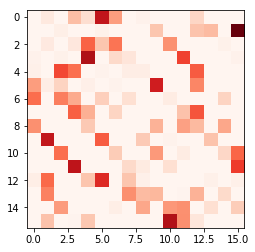

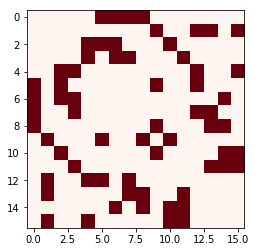

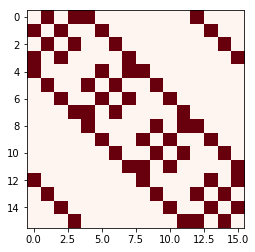

In [164]:
prediction = alpha_time[:,:,91200]
prediction = np.squeeze(prediction)
normalizer = np.sum(prediction,axis=1)
normalizer = np.outer(normalizer, np.ones(prediction.shape[1]))
prediction = prediction/normalizer

plt.imshow(prediction,cmap='Reds')
plt.show()

ref_B = np.zeros([rooms,rooms])
theta = links(env_B, rooms)
for i in range(rooms):
    ref_B[i,(theta[i,:]-1).astype(int)] = 0.25
    
plt.imshow(ref_B,cmap='Reds')
plt.show()


ref_A = np.zeros([rooms,rooms])
theta = links(env_A, rooms)
for i in range(rooms):
    ref_A[i,(theta[i,:]-1).astype(int)] = 0.25
    
plt.imshow(ref_A,cmap='Reds')
plt.show()